In [7]:
from numpy import sqrt, exp, log, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import date,datetime,timedelta
import warnings
#from scipy.interpolate import griddata
import plotly.graph_objects as go
from arch import arch_model
import nbformat
from matplotlib.colors import Normalize
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "notebook_connected"
warnings.filterwarnings("ignore")

In [21]:
class IVCalculator:
    def __init__(self, ticker, option_type, oi_lower_bound):
        self.ticker = ticker
        self.option_type = option_type
        self.oi_lower_bound = oi_lower_bound
        self.S_ticker = self.get_last_closing_price()
        self.r_1y = self.get_interest_rate()
        self.data_options = self.load_options_data()
    def get_last_closing_price(self):
        """
        Downloads the latest spot price for the given ticker.
        """
        return yf.download(self.ticker)["Close"].iloc[-1].iat[-1]
    def get_interest_rate(self):
        """
        Downloads the most recent 1-year US-T yield.
        """
        return yf.download("^IRX")["Close"].iloc[-1].iat[-1] / 100
    def load_options_data(self):
        """
        Auxiliary function to load data and drop missing values. 
        """
        data = self.options_data(self.ticker, self.option_type, self.oi_lower_bound)
        return data.dropna()
    def options_data(self, ticker, option_type="call", oi_lower_bound=100):
        """
        Downloads the options data based on specified ticker, option type and
        minimum value of open interest (oi_lower_bound). Lower bound for open
        interest serves the purpose of disregarding illiquied, barely trade
        option contracts. Lowering the OI lower bound may result in lower
        ability of the algorithm to solve for the correct IV. 
        """
        asset = yf.Ticker(ticker)
        exp_dates = asset.options
        data = pd.DataFrame()

        for exp in exp_dates:
            options = asset.option_chain(exp)
            calls = options.calls
            calls["optionType"] = "call"
            puts = options.puts
            puts["optionType"] = "put"
            d = pd.concat([calls, puts])
            d["expiration"] = pd.to_datetime(exp) + pd.DateOffset(hours=23, minutes=59, seconds=59)
            data = pd.concat([data, d])

        data["dte"] = (data["expiration"] - dt.datetime.today()).dt.days + 1
        data = data[["strike", "lastPrice", "volume", "openInterest", "optionType", "dte", "impliedVolatility"]]
        data = data[data["openInterest"] > oi_lower_bound]

        if option_type == "call":
            return data[data["optionType"] == "call"]
        elif option_type == "put":
            return data[data["optionType"] == "put"]
        else:
            return data
    def objective_function(self, sigma, args):
        """
        Objective function for later optimization. Takes the theoretical
        option price(option_price) and the price observed on the market (price)
        and subtracts one from another.
        """
        S, K, r, t, price = args
        return self.option_price(sigma, S, K, r, t, type=self.option_type) - price

    def calculate_vega(self, sigma, args):
        """ 
        Calculates vega, a derivative of the option price according to
        BS fomula w.r.t sigma. It is necessary since the Newton's
        algorithm requires a derivative of a function as an input.
        """
        S, K, r, t = args[:4]

        d1 = (np.log(S / K) + (r + sigma ** 2 / 2.) * t) / (sigma * np.sqrt(t))
        return S * norm.pdf(d1) * np.sqrt(t)
    def newtons_method(self, f, fprime, R=0, max_iter=1000, tol=1e-3, args=[], debug=False):
        """ 
        Newton's algorithm, which will solve numerically for the value of sigma.
        """
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error", RuntimeWarning)
                count, epsilon = 0, 1

                while epsilon >= tol:
                    count += 1
                    if count >= max_iter:
                        print('Forced exit, the loop runs away')
                        return (R, count)

                    old_R = R
                    function_value = f(R, args=args)
                    function_derivative = fprime(R, args=args)
                    R -= function_value / function_derivative

                    epsilon = np.abs((R - old_R) / old_R)
                    if debug == True:
                        print('Iteration = ', count, 'f = ', function_value, 'fprime = ', function_derivative, 'Tol = ', epsilon)

                return R
        except (RuntimeWarning, Exception):
            return None
    def compute_iv(self):
        """ 
        Calculate IV by applying the Newton's method and add it as a seperate
        column to the data_options data frame.
        """
        self.data_options["iv"] = self.data_options.apply(
            lambda row: self.newtons_method(
                self.objective_function,
                self.calculate_vega,
                R=0.5,
                args=[self.S_ticker, row["strike"], self.r_1y, float(row["dte"] / 365), row["lastPrice"]]
            ), axis=1
        )
        return self.data_options

    def option_price(self, sigma, S, K, r, t, type="call"):
        """
        Calculate the theoretical option price based on Black-Scholes model.
        It is used to form objective_function, which is then used to find
        the solution. 
        """
        d1 = (np.log(S / K) + (r + sigma ** 2 / 2.) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        if type == "call":
            return S * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
        elif type == "put":
            return K * np.exp(-r * t) * norm.cdf(-d2) - S * norm.cdf(-d1)
        else:
            print("You must specify the type correctly (call or put)!!!")
            return None
    def plot_iv_values(self):
        data = self.data_options
        if "iv" not in self.data_options.columns:
            raise ValueError("not computed yet")
        x = data['strike'].values
        y = data['dte'].values
        z = data['iv'].values

        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        norm = Normalize(vmin=data["iv"].min(), vmax=data["iv"].max())
        scatter = ax.scatter(x, y, z, c=z, cmap='viridis', norm=norm)

        cbar = plt.colorbar(scatter, ax=ax, shrink=0.5)
        cbar.set_label('Implied Volatility values')

        ax.set_xlabel('Strike prices')
        ax.set_ylabel('DTE (Days to Expiration)')
        ax.set_zlabel('IV (Implied Volatility)')

        ax.set_title('Implied Volatility')

        plt.show()

In [28]:
aapl = IVCalculator("AAPL","call",100)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


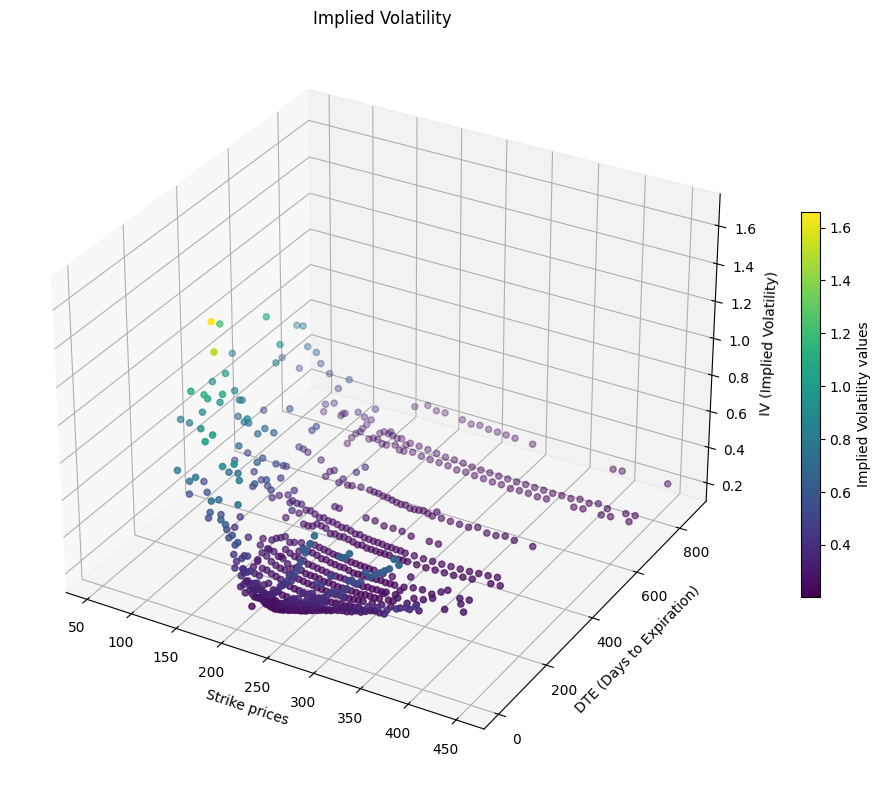

In [29]:
aapl.compute_iv()
aapl.plot_iv_values()